In [4]:
pip install rocketpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 KB 581.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 KB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.5 MB/s eta 0:00:00
  Created wheel for simplekml: filename=simplekml-1.3.6-py3-none-any.whl size=65875 sha256=da188a38e132bd7e03d5f7be2ad1c6ef4f269c24e3cdabd4a10a904ac2900258
  Stored in directory: /root/.cache/pip/wheels/61/7c/b1/a15afd1959498020ff45abc6e309b5c48975a5d741e60c5922
Successfully built simplekml
  Attempting uninstall: netCDF4
    Found existing installation: netCDF4 1.6.2
    Uninstalling netCDF4-1.6.2:
      Successfully uninstalled netCDF4-1.6.2


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


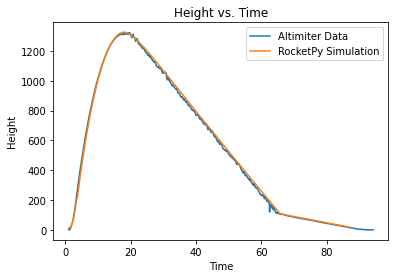

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from rocketpy import Environment,Rocket,SolidMotor,Flight
from mpl_toolkits import mplot3d
import datetime
from rocketpy.EnvironmentAnalysis import EnvironmentAnalysis
import os
import csv
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# This one is able to view events in the past, others you have to download .nc files to view
EnvWUAS= Environment(
    railLength=3.66,
    latitude=35.1431,
    longitude=-76.8126,
    elevation=5,
    date=(2023, 2, 26),
)

URL = "http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2023&MONTH=02&FROM=2612&TO=2618&STNM=72305"

EnvWUAS.setAtmosphericModel(type="WyomingSounding", file=URL)

#EnvWUAS.info()

L1520T = SolidMotor(
        thrustSource="/content/drive/MyDrive/Rocketpy/AeroTech_L1520T.eng",
    burnOut=2.4,
    grainNumber=3,
    grainSeparation= 0.0016,
    grainDensity= 1625,
    grainOuterRadius= 0.031661,
    grainInitialInnerRadius= 0.011112,
    grainInitialHeight= 0.1318,
    nozzleRadius= 0.023813,
    throatRadius= 0.0086995,
    interpolationMethod="linear",
)

FullScale = Rocket(
    motor=L1520T,
    radius=0.07835,
    mass= (42.5/2.205)-L1520T.propellantInitialMass,
    inertiaI=10.185,
    inertiaZ=0.0528,
    distanceRocketNozzle=-1.375,
    distanceRocketPropellant=-0.89,
        powerOffDrag="/content/drive/MyDrive/Rocketpy/OR_power_off_validated.csv",
        powerOnDrag="/content/drive/MyDrive/Rocketpy/OR_power_on_validated.csv",
)

FullScale.setRailButtons([-0.275, -1.185]) 

NoseCone = FullScale.addNose(length=.76, kind="ogive", distanceToCM=0.8)

FinSet = FullScale.addTrapezoidalFins(
    n=4,
    rootChord=0.26,
    tipChord=0.1,
    span=0.15,
    distanceToCM=-0.955,
    cantAngle=0,
    radius=None,
    airfoil=None,
)

Tail = FullScale.addTail(
    topRadius=0.0787, bottomRadius=0.0508, length=0.155, distanceToCM=-1.22
)

def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False


def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 800 + 1400 m (+1400 due to surface elevation).
    return True if y[5] < 0 and y[2] < 140 + EnvWUAS.elevation else False


Main = FullScale.addParachute(
    "Main",
    CdS=15.55,
    trigger=mainTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = FullScale.addParachute(
    "Drogue",
    CdS= 0.4,
    trigger=drogueTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

# Simulate first 5 seconds of Flight
TestFlight = Flight(
    rocket=FullScale,
    environment=EnvWUAS,
    inclination=90,
    heading=0,
    maxTimeStep=0.01,
    maxTime=800,
)
TestFlight.postProcess()


df = pd.read_csv('/content/drive/MyDrive/Rocketpy/main_alt.csv')
time = df['time']
time += 1
height = df['height']


# Stability and Control variables
# Angular velocities frequency response - Fourier Analysis
# Omega 1 - w1
Fs = 100.0
# sampling rate
Ts = 1.0 / Fs
# sampling interval
t = np.arange(1, TestFlight.tFinal, Ts)  # time vector





z = TestFlight.z[:,1]
plt.figure()
plt.plot(time, height,label='Altimiter Data')
plt.plot(t, z[:len(t)],label='RocketPy Simulation')
plt.xlabel('Time')
plt.ylabel('Height')
plt.title('Height vs. Time')
plt.legend()
plt.show()
#TestFlight.allInfo()